In [1]:
import warnings
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from config import *
from model import autoencoder
from scipy.spatial.transform import Rotation as R

In [2]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
from utils.Quaternions import Quaternions

In [3]:
data = np.load("../data/01_data.npz")
X = data["clips"].astype(np.float64)
Xmean = X.mean(axis=(0, 1))[np.newaxis, np.newaxis, :]
Xstd = X.std(axis=(0, 1))[np.newaxis, np.newaxis, :]
# Xstd = np.full((1, 1, X.shape[2]), X.std())

In [4]:
autoencoder.load_weights("../weights/01-autoencoder.weights.h5")

In [5]:
X = (X - Xmean) / (Xstd + 1e-8)
x_recon = autoencoder.predict(X)
x_recon = x_recon * (Xstd + 1e-8) + Xmean

304/304 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


In [20]:
sample_idx = np.random.randint(0, X.shape[0])

In [21]:
x_sample = x_recon[sample_idx][np.newaxis, :]

In [22]:
def animate_plot(animations):
    processed_animations = []
    for anim in animations[:1]:
        joints = anim[:, :-3].reshape((WINDOW_SIZE, NUM_JOINTS, 3))
        root_x, root_z, root_r = anim[:, -3], anim[:, -2], anim[:, -1]

        rotation = Quaternions.id(1)
        translation = np.array([[0.0, 0.0, 0.0]])

        for i in range(len(joints)):
            joints[i] = rotation * joints[i]
            joints[i, :, 0] = joints[i, :, 0] + translation[0, 0]
            joints[i, :, 2] = joints[i, :, 2] + translation[0, 2]

            rotation = (
                Quaternions.from_angle_axis(-root_r[i], np.array([0, 1, 0])) * rotation
            )
            translation = translation + rotation * np.array([root_x[i], 0, root_z[i]])

        processed_animations.append(joints)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    all_joints = np.concatenate(processed_animations, axis=0)
    xs, ys, zs = all_joints[:, :, 0], all_joints[:, :, 1], all_joints[:, :, 2]
    ax.set_xlim(xs.min() - 1, xs.max() + 1)
    ax.set_ylim(ys.min() - 1, ys.max() + 1)
    ax.set_zlim(zs.min() - 1, zs.max() + 1)

    ax.view_init(elev=45, azim=0, roll=90)
    scatters = []
    bone_lines = []

    for joints in processed_animations:
        scatter = ax.scatter([], [], [], s=50, c="dodgerblue")
        scatters.append(scatter)

        lines = []
        for bone in BONES:
            (line,) = ax.plot([], [], [], "dodgerblue", linewidth=8, solid_capstyle='round')
            lines.append(line)
        bone_lines.append(lines)

    def update(frame):
        for i, joints in enumerate(processed_animations):
            scatters[i]._offsets3d = (
                joints[frame, :, 0],
                joints[frame, :, 1],
                joints[frame, :, 2],
            )

            for j, (start_joint, end_joint) in enumerate(BONES):
                if start_joint < joints.shape[1] and end_joint < joints.shape[1]:
                    x_data = [
                        joints[frame, start_joint, 0],
                        joints[frame, end_joint, 0],
                    ]
                    y_data = [
                        joints[frame, start_joint, 1],
                        joints[frame, end_joint, 1],
                    ]
                    z_data = [
                        joints[frame, start_joint, 2],
                        joints[frame, end_joint, 2],
                    ]

                    bone_lines[i][j].set_data(x_data, y_data)
                    bone_lines[i][j].set_3d_properties(z_data)

        ax.set_title(f"Frame {frame}")
        return scatters + [line for lines in bone_lines for line in lines]

    return animation.FuncAnimation(fig, update, frames=160, interval=50, repeat=True)

In [23]:
x_test = data['clips'][sample_idx][np.newaxis, :]
x_test.shape

(1, 160, 63)

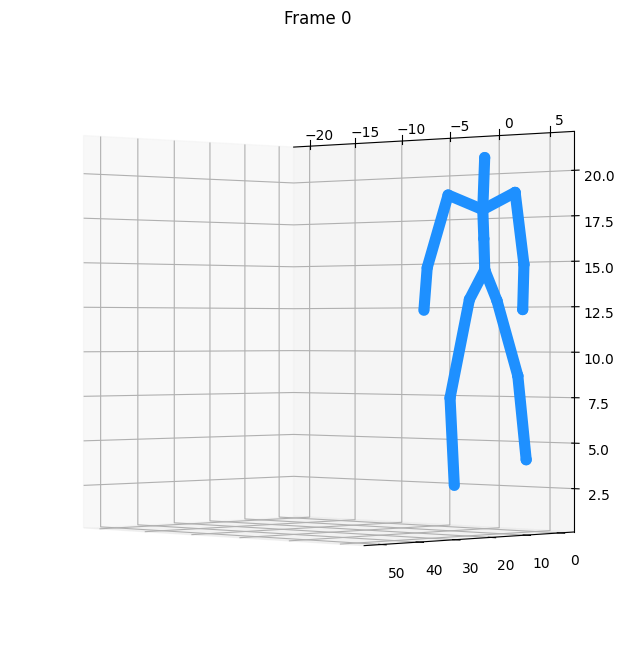

In [24]:
%matplotlib inline
from IPython.display import HTML
ani = animate_plot(x_sample)
HTML(ani.to_jshtml())

In [25]:
import matplotlib.animation as animation
print("Available writers:", animation.writers.list())

Available writers: ['pillow', 'html']


In [26]:
ani.save('03.gif', writer='pillow', fps=30)

In [27]:
sample_idx

2385